ランタイムの接続が切れないようにするJavaScriptコード
DevToolsのコンソールに入力

JavaScript code to stop for the runtime to disconnect 

```javascript
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click();
}
setInterval(KeepClicking,60000);
```



# データのインポート import data
google driveをマウント

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ライブラリの読み込みなど

Load libraries and more

In [7]:
# tensorflow
import tensorflow as tf
from tensorflow import keras

import os
import numpy as np
import IPython.display as display
import random
import matplotlib.pyplot as plt
import pathlib

AUTOTUNE = tf.data.experimental.AUTOTUNE

作業ディレクトリの移動とデータの読み込み

Change the working directory and load labels.txt and handwriting images

/content/drive/MyDrive/colab/hisseki_test_py


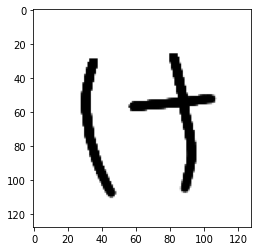

In [13]:
%cd /content/drive/MyDrive/colab/hisseki_test_py

def preprocess_image(image):
  image_4ch = tf.image.decode_image(image, channels=4, expand_animations=False)
  image_4ch = tf.image.resize(image_4ch, [128, 128])
  # image = tf.cast(tf.reduce_sum(image_4ch, 2, keepdims=True), tf.float32)
  # image /= 255.0  # normalize to [0,1] range
  image_4ch /= 255.0

  return image_4ch

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

label_file = open("tf_datas/labels.txt")
labels_str = label_file.readlines()
label_file.close()
label_int = list(map(lambda str: int(str), labels_str))

data_num = len(label_int)
image_paths = []
for i in range(data_num):
  image_paths.append("/content/drive/MyDrive/colab/hisseki_test_py/tf_datas/hisseki%d.png" % i)

path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(label_int, tf.int64))

# ランダムに画像をテスト表示
# randomly choose a handwriting image and show to test
plt.imshow(random.choice(list(image_ds)))
plt.grid(False)
plt.show()

image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

教師データの前処理

Preprocess training data

In [17]:
BATCH_SIZE = 32

ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=data_num))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 128, 128, 4), (None,)), types: (tf.float32, tf.int64)>

モデルの設定

Set model

In [23]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(128, 128, 4)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(data_num, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_5 (Dense)              (None, 173)               22317     
Total params: 8,411,053
Trainable params: 8,411,053
Non-trainable params: 0
_________________________________________________________________


訓練

Train

In [24]:
model.fit(ds, epochs=10, steps_per_epoch=10)

Epoch 1/10
10/10 [==============================] - 2s 88ms/step - loss: 2.2098 - accuracy: 0.5406
Epoch 2/10
10/10 [==============================] - 1s 91ms/step - loss: 0.0984 - accuracy: 0.9781
Epoch 3/10
10/10 [==============================] - 1s 90ms/step - loss: 0.0373 - accuracy: 0.9969
Epoch 4/10
10/10 [==============================] - 1s 88ms/step - loss: 0.0174 - accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 1s 92ms/step - loss: 0.0325 - accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 1s 88ms/step - loss: 0.0323 - accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 1s 84ms/step - loss: 0.0321 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 1s 89ms/step - loss: 0.0320 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 1s 87ms/step - loss: 0.0319 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 1s 87ms/step - loss: 0.0160 - accuracy: 1.0000
